# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 1:Business Understaning

The starbucks data give a situation about Sale Promotion with cupon. It give the customers a discount of BOGO(buy one get one free), which will prompt the sale if the customer use it. Customer get discount, starbuck get sale promotion and build customer potential consumption pattern.

Offers is a sales promotion strategy, which will increase the cost by instinct. For maximize the effort, we would like to find out a better way for offer delivery:
1. Does offers change customer behavior?
2. Does the change of customer behavior make more profit?

Final Goal:
1. Can we find a way to control the cost of offers, or get more profit from offers?

# Section 2:Data Understaning

## 1. Gather

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import re
import math
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Gaather Data#
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
print(profile.info())
profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [5]:
print(transcript.info())
transcript.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
print(portfolio.info())
portfolio.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## 2. Cleaning

### 2.1 Cleaning "profile"

1. There are a lot of customers at age 118.Those are the people who do not want to give the age informations. We will consider that as a NaN.
2. "id" in profile is a hashtag, we will replace it with numbers for clearity.

In [7]:
def create_user_id_map(data=profile):
    """
    Create a map for hashed 'person' in profile to simplify the data
    Parameters
    -------
    data : the profile dataframe
    Returns
    ---------
    user_id_map: The map DataFrame between hashed person informations and
    interger numbers
    """
    user_id_map = pd.DataFrame(
        {'person': data['id'],
         'person_id': range(len(data['id']))}
    )
    return user_id_map


user_id_map = create_user_id_map()


def clean_profile_(data=profile, user_id_map=user_id_map):
    """
    Clean the profile dataframe.
    1. if the ages are above 117, treat this as Nan
    2. replace hashed 'person' into 'person_id'
    Parameters
    ------
    data : The profile dataframe.
    user_id_map : The dataframe contains the relations between hashed 'person' and 'person_id'
    Returns
    -------
    profile_new : The cleaned version of profile
    """
    profile_new = data.merge(user_id_map, how='left', left_on='id', right_on='person')
    profile_new.drop(['id', 'person'], axis=1, inplace=True)
    profile_new.loc[profile_new['age'] >= 117, 'age'] = np.nan
    # profile_new['income']  = np.log10(profile_new['income'])
    profile_new['became_member_on'] = pd.to_datetime(data['became_member_on'], format='%Y%m%d')
    return profile_new


clean_profile = clean_profile_()
%store clean_profile
clean_profile.head()

Stored 'clean_profile' (DataFrame)


,gender,age,became_member_on,income,person_id
0,None,NaN,2017-02-12,NaN,0
1,F,55.0,2017-07-15,112000.0,1
2,None,NaN,2018-07-12,NaN,2
3,F,75.0,2017-05-09,100000.0,3
4,None,NaN,2017-08-04,NaN,4


### 2.2 Cleaning "portfolio". 

1. Replace id with offer_id base on id mapping table.
2. Split channels into columns.

In [8]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [9]:
# map dict for hashed offer id 
map_dict = {'offer_id': ['BOGO_r10_d10_u7',
                         'BOGO_r10_d10_u5',
                         'INFO_u4',
                         'BOGO_r5_d5_u7',
                         'DIS_r5_d20_u10',
                         'DIS_r3_d7_u7',
                         'DIS_r2_d10_u10',
                         'INFO_u3',
                         'BOGO_r5_d5_u5',
                         'DIS_r2_d10_u7']}
offer_id_map = pd.DataFrame(map_dict)
offer_id_map = offer_id_map.merge(portfolio.loc[:, 'id'], left_index=True, right_index=True)
offer_id_map.rename(columns={'id': 'portfolio_id'}, inplace=True)
offer_id_map

,offer_id,portfolio_id
0,BOGO_r10_d10_u7,ae264e3637204a6fb9bb56bc8210ddfd
1,BOGO_r10_d10_u5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,INFO_u4,3f207df678b143eea3cee63160fa8bed
3,BOGO_r5_d5_u7,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,DIS_r5_d20_u10,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,DIS_r3_d7_u7,2298d6c36e964ae4a3e7e9706d1fb8c2
6,DIS_r2_d10_u10,fafdcd668e3743c1bb461111dcafc2a4
7,INFO_u3,5a8bc65990b245e5a138643cd4eb9837
8,BOGO_r5_d5_u5,f19421c1d4aa40978ebb69ca19b0e20d
9,DIS_r2_d10_u7,2906b810c7d4411798c6938adc9daaa5


In [10]:
def clean_portfolio(portfolio=portfolio, offer_id_map=offer_id_map):
    """
    clean the portfolio data, change hashed "ID" into "offer_id" according to offer_id_map
    split channels into columns
    Parameters
    -----
    portfolio : The original profile dataframe
    offer_id_map : The dataFrame map between hased 'id' and more readable 'offer_id'.
    Returns
    -----
    port_clean : the cleaned version of profile
    """
    port_clean = portfolio.copy()
    channel_list = []
    for channel in portfolio['channels']:
        channel_list.extend(channel)
    channel_set = set(channel_list)
    
    # convert channels into dummies
    for channel in channel_set:
        port_clean['channel_' + channel] = port_clean['channels'].apply(lambda x: 1 if  x.count(channel)>0 else 0)
        
    # change id according to offer_id_map
    
    port_clean = port_clean.merge(offer_id_map, left_on= 'id', right_on = 'portfolio_id')
        
    
    port_clean.drop(['channels','id', 'portfolio_id'], axis = 1, inplace = True)
    return port_clean


portfolio_clean = clean_portfolio()
%store portfolio_clean

Stored 'portfolio_clean' (DataFrame)


In [11]:
portfolio_clean

,reward,difficulty,duration,offer_type,channel_social,channel_email,channel_web,channel_mobile,offer_id
0,10,10,7,bogo,1,1,0,1,BOGO_r10_d10_u7
1,10,10,5,bogo,1,1,1,1,BOGO_r10_d10_u5
2,0,0,4,informational,0,1,1,1,INFO_u4
3,5,5,7,bogo,0,1,1,1,BOGO_r5_d5_u7
4,5,20,10,discount,0,1,1,0,DIS_r5_d20_u10
5,3,7,7,discount,1,1,1,1,DIS_r3_d7_u7
6,2,10,10,discount,1,1,1,1,DIS_r2_d10_u10
7,0,0,3,informational,1,1,0,1,INFO_u3
8,5,5,5,bogo,1,1,1,1,BOGO_r5_d5_u5
9,2,10,7,discount,0,1,1,1,DIS_r2_d10_u7


In [12]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### 2.3 Cleaning "transcript"

1. replace person hashvalue with numeric person_id.
2. extract information from value column.
3. replace offer hashvalue with numeric offer_id.

In [13]:
# Clean ###
def elementary_transcript(transcript = transcript, portfolio = portfolio_clean, offer_id_map = offer_id_map, user_id_map = user_id_map):
    """
    clean the transcript data, use person_id, offer_id instead of hash number.
    Parameters
    ------------
    transcript : The transcript DataFrame
    portfolio : The cleaned portfolio DataFrame
    offer_id_map : The offer id map dataFrame
    user_id_map : The user id map dataFrame
    Returns
    ------------
    transcript_clean : The elementary cleaned transcript DataFrame
    """
    
    # simplify person to person_id
    transcript_clean = transcript.copy()    

    transcript_clean = transcript_clean.merge(user_id_map, on = 'person')    
    print(transcript_clean.event.unique())
    # 
    
    transcript_clean['portfolio_id'] = transcript_clean['value'].apply(
        lambda x : x.get('offer_id', np.nan) if (x.get('offer id', np.nan) is np.nan) else x.get('offer id', np.nan)
    )


    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x :x.get('amount', np.nan))

    transcript_clean['reward'] = transcript_clean['value'].apply(lambda x :x.get('reward', np.nan))
    transcript_clean = transcript_clean.merge(offer_id_map,how = 'left', on = 'portfolio_id')
#    transcript_clean['offer_id'] = transcript_clean['offer_id'].astype('Int64')
    transcript_clean.drop(['person','value', 'portfolio_id'], axis = 1, inplace = True)
    portfolio.rename(columns={'reward':'offer_reward'},inplace=True)
    transcript_clean = transcript_clean.merge(portfolio, on='offer_id',how='left')
    return transcript_clean

elementary_trans = elementary_transcript()
%store elementary_trans
elementary_trans.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']
Stored 'elementary_trans' (DataFrame)


,event,time,person_id,amount,reward,offer_id,offer_reward,difficulty,duration,offer_type,channel_social,channel_email,channel_web,channel_mobile
0,offer received,0,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0
1,offer viewed,6,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0
2,transaction,132,3,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,132,3,NaN,5.0,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0
4,transaction,144,3,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
elementary_trans['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## 3. Data Explore 

### 3.1 Basic histogram


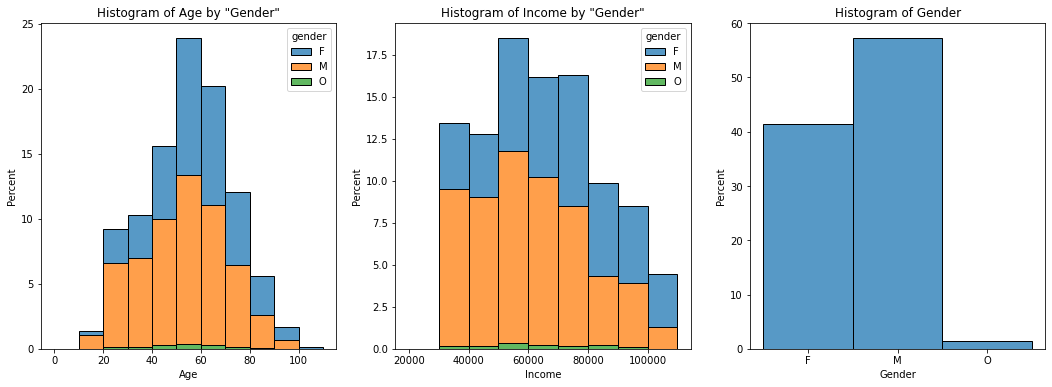

In [12]:
### Visualize ###
## plot the histogram of age , income
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
sns.histplot(clean_profile, x = 'age', hue = 'gender', ax = ax1, multiple = 'stack', stat='percent' ,bins = range(0, 120, 10))
ax1.set_title('Histogram of Age by "Gender"')
ax1.set_xlabel('Age')

sns.histplot(clean_profile, x = 'income', hue = 'gender', ax = ax2, multiple = 'stack' ,stat='percent', bins = range(20000, 120000, 10000))
ax2.set_title('Histogram of Income by "Gender"')
ax2.set_xlabel('Income')

sns.histplot(clean_profile, x = 'gender',stat='percent', ax = ax3)
ax3.set_title('Histogram of Gender')
ax3.set_xlabel('Gender')
plt.show()

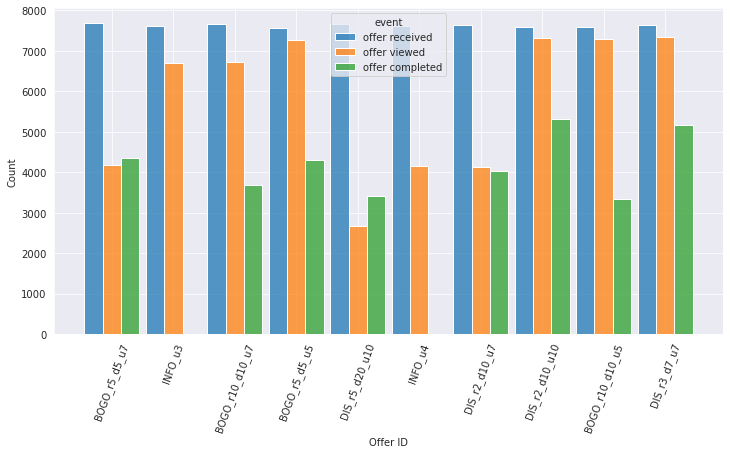

In [178]:
plt.figure(figsize=(12,6))
sns.histplot(elementary_trans[elementary_trans['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
             x= 'offer_id', hue='event', multiple='dodge', shrink=0.9,
             hue_order=['offer received', 'offer viewed', 'offer completed'])
plt.xticks(rotation=70)
plt.xlabel('Offer ID')
plt.show()

The count of offer completed are even more than the count of offer viewed in some offers, we need to clean thease data.

In [ ]:
def get_index_unusual(person_trans):
    offer_df = person_trans[['offer_id','duration']].dropna().drop_duplicates()
    vct_table = person_trans.reset_index()
    vct_table.fillna({'offer_id':'trans'}, inplace=True)
    vct_pivot = vct_table.pivot(index='index', columns=['offer_id', 'event'], values='time')
    offer_list = vct_pivot.columns.get_level_values(0).unique().tolist()
    bogo_dis = re.compile('^DIS|BOGO')
    offer_list = list(filter(bogo_dis.match, offer_list))

    unseq = []
    for offer in offer_list:
        viewed_offer = []
        df1 = vct_pivot[offer].dropna(how='all')
        #print(df1)
        for row in df1.index:
            try:
                if  pd.notnull(df1.loc[row,'offer received']):

                    val = df1.loc[row,'offer received'] + offer_df.loc[offer_df['offer_id'] == offer, 'duration'].values *24
                    #print(0)
                elif pd.notnull(df1.loc[row,'offer viewed']):
                    #print(viewed_offer)
                    viewed_offer.append(int(val[0]))
                    val = []
                    #print(1)

                elif len(viewed_offer) > 0:
                    # print(2)
                    while (len(viewed_offer) >0) and (df1.loc[row,'offer completed'] <= viewed_offer[0]):
                        viewed_offer.pop(0)
                        #print('pop one number')
                    
                    if len(viewed_offer) > 0:
                        viewed_offer.pop(0)
                    #else:
                     #   remain = df1.loc[row:,'offer completed']
                      #  unseq = unseq + remain[~remain.isnull()].tolist()                        
                else:
                    remain = df1.loc[row:,'offer completed']
                    unseq = unseq + remain[~remain.isnull()].tolist()
                    #print(3)
            except Exception:
                #print(repr(Exception))
                remain = df1.loc[row:,'offer completed']
                unseq = unseq + remain[~remain.isnull()].tolist()
    index_turn = person_trans[person_trans['time'].isin(unseq)].index
    return index_turn


a = get_index_unusual(person_13)
b = get_index_unusual(person_14)


In [ ]:
def remove_unviewed_offer(df):
    index_unusual = pd.Index([])
    for person in df['person_id'].unique():
        index_ = get_index_unusual(df[df['person_id'] == person])
        index_unusual = index_unusual.append(index_)
    return index_unusual


index_unusual = remove_unviewed_offer(elementary_trans)


In [ ]:
index_unusual.shape
elementary_trans_ = elementary_trans.loc[np.setdiff1d(elementary_trans.index, index_unusual)]

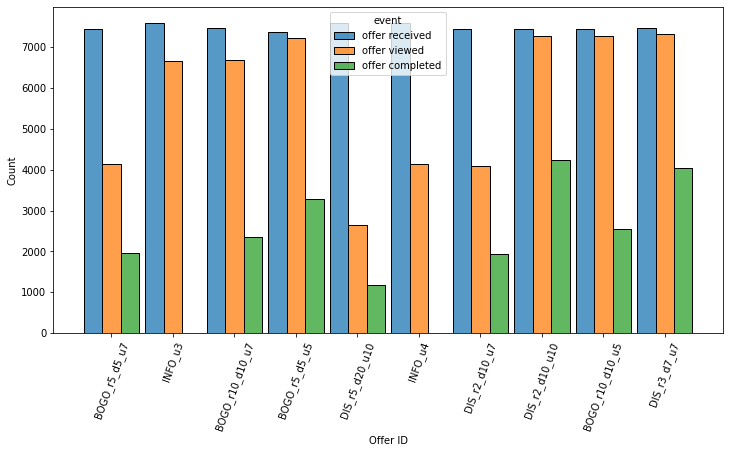

In [45]:
plt.figure(figsize=(12,6))
sns.histplot(elementary_trans_[elementary_trans_['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
             x= 'offer_id', hue='event', multiple='dodge', shrink=0.9,
             hue_order=['offer received', 'offer viewed', 'offer completed'])
plt.xticks(rotation=70)
plt.xlabel('Offer ID')
plt.show()

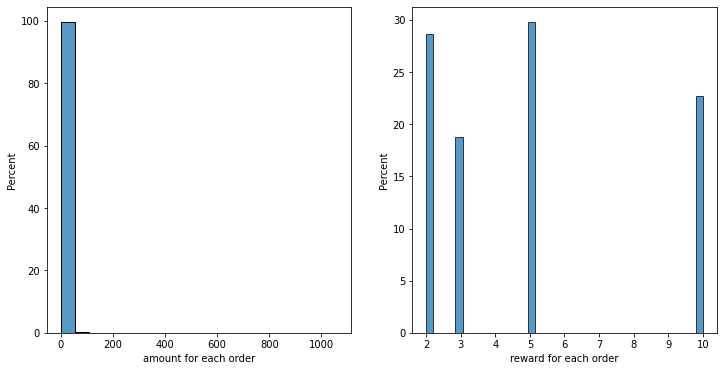

In [47]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))

sns.histplot(elementary_trans_, x = 'amount', stat='percent', ax = ax0, bins = 20)
ax0.set_xlabel('amount for each order')
sns.histplot(elementary_trans_, x = 'reward', stat='percent', ax = ax1)
ax1.set_xlabel('reward for each order')
plt.show()



### 3.2 Anaylize 


The most important information is how the comsumers responed to offers. So we will dig deeper in "transaction" 

As we want to find out the influence of offers, 
The offers which have the same viewed time and completed time, do not reflect how the customers react to offers.
we will remove these from data.

In [48]:
# Clean ###
def trans_reward_(transcript=elementary_trans):
    """
    summary the transcript for each transaction. Find out the offer useage and reward for each transaction.
    Parameters
    ----------
    transcript : the Dataframe of transcript after elementary clean
    Returns
    ----------
    trans_reward : The dataframe of the summary of transcript with reward informations.
    """
    groupby_person_time = transcript[transcript['event'] == 'offer completed'].groupby(['person_id', 'time'])
    sum_reward = groupby_person_time[['reward','offer_reward']].sum().reset_index()
    channel = groupby_person_time[['channel_mobile','channel_web','channel_email','channel_social']].max().reset_index()
    offer_difficulty = groupby_person_time[['difficulty']].max().reset_index()
    offer_duration = groupby_person_time['duration'].max().reset_index()

    count_complete_offer = transcript[transcript['event'] == 'offer completed'].groupby(['person_id', 'time','offer_id'])['reward'].count().unstack()
    count_complete_offer['offer_used'] = count_complete_offer.sum(axis = 1)

    trans = transcript[transcript['event'] == 'transaction']
    trans = trans[['person_id','time','amount']].copy()
    trans_reward = trans.merge(sum_reward, on = ['person_id','time'], how = 'left')
    trans_reward = trans_reward.merge(count_complete_offer, on = ['person_id','time'], how = 'left')
    trans_reward = trans_reward.merge(channel, on = ['person_id','time'], how = 'left')
    trans_reward = trans_reward.merge(offer_difficulty, on = ['person_id','time'], how = 'left')
    trans_reward = trans_reward.merge(offer_duration, on = ['person_id','time'], how = 'left')

    trans_reward['bogo'] = trans_reward.filter(regex = '^BOGO', axis = 1).any(axis = 1)
    trans_reward['discount'] = trans_reward.filter(regex = '^DIS', axis = 1).any(axis = 1)

    return trans_reward


trans_reward = trans_reward_(elementary_trans_)
%store trans_reward
trans_reward.head()

Stored 'trans_reward' (DataFrame)


,person_id,time,amount,reward,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,offer_used,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration,bogo,discount
0,3,132,19.89,5.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,5.0,7.0,True,False
1,3,144,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,3,222,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,3,240,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,3,378,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [49]:
#find out are there transactions use both BOGO and DISCOUNT.
bogo_or_discount = trans_reward[trans_reward['bogo'] | trans_reward['discount']]
bogo_and_discount = bogo_or_discount['bogo'] & bogo_or_discount['discount']
print('About {}% of the transactions use both BOGO and DISCOUNT. '.format(round(bogo_and_discount.mean()*100)))

About 2% of the transactions use both BOGO and DISCOUNT. 


About 5% of the transactions use both BOGO and Discount, for better modeling, we will remove those transactions.

In [50]:
trans_reward.describe()

,person_id,time,amount,reward,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,offer_used,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration
count,128899.000000,128899.000000,128899.000000,20563.000000,20563.000000,2536.000000,2340.000000,3269.000000,1949.000000,4221.000000,1934.000000,4040.0,1172.000000,20563.000000,20563.000000,20563.000000,20563.0,20563.000000,20563.000000,20563.000000
mean,8514.516272,378.386256,12.115383,5.116471,5.116471,1.000789,1.000427,1.001224,1.000513,1.000711,1.001034,1.0,1.000853,1.044352,0.950737,0.896319,1.0,0.776589,8.834217,7.259203
std,4902.035227,202.827590,29.284055,3.233662,3.233662,0.028077,0.020672,0.034964,0.022651,0.026653,0.032150,0.0,0.029210,0.209161,0.216422,0.304854,0.0,0.416542,3.449793,1.824922
min,0.000000,0.000000,0.050000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,5.000000,5.000000
25%,4289.000000,210.000000,2.540000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,7.000000,5.000000
50%,8537.000000,396.000000,7.910000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,10.000000,7.000000
75%,12740.000000,552.000000,17.290000,7.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,10.000000,10.000000
max,16999.000000,714.000000,1062.280000,22.000000,22.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,3.000000,1.000000,1.000000,1.0,1.000000,20.000000,10.000000


We can see there are pretty big outliers in 'amount'.We will use IQR method to remove the outliers.

In [51]:
Q1 = trans_reward['amount'].quantile(0.25)
Q3 = trans_reward['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

trans_reward = trans_reward[(trans_reward['amount'] < upper_bound) & (trans_reward['amount'] > lower_bound)]
%store trans_reward

Stored 'trans_reward' (DataFrame)


In [52]:
trans_reward.describe()

,person_id,time,amount,reward,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,offer_used,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration
count,127641.000000,127641.000000,127641.000000,20115.000000,20115.000000,2459.000000,2268.000000,3188.000000,1926.000000,4140.000000,1889.000000,3969.0,1138.000000,20115.000000,20115.000000,20115.000000,20115.0,20115.000000,20115.000000,20115.000000
mean,8515.075477,378.336146,10.512031,5.098931,5.098931,1.000813,1.000441,1.001255,1.000519,1.000725,1.001059,1.0,1.000879,1.043550,0.950932,0.897191,1.0,0.775789,8.822073,7.261546
std,4901.693205,202.790794,9.193379,3.223604,3.223604,0.028513,0.020998,0.035405,0.022786,0.026913,0.032530,0.0,0.029643,0.207238,0.216015,0.303717,0.0,0.417072,3.444341,1.823703
min,0.000000,0.000000,0.050000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,5.000000,5.000000
25%,4290.000000,210.000000,2.510000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,7.000000,5.000000
50%,8538.000000,396.000000,7.750000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,10.000000,7.000000
75%,12744.000000,552.000000,16.980000,7.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,10.000000,10.000000
max,16999.000000,714.000000,39.410000,22.000000,22.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,3.000000,1.000000,1.000000,1.0,1.000000,20.000000,10.000000


In [53]:
# For better analysis and model we remove the infos which use both BOGO and DISCOUNT
trans_reward = trans_reward[~(trans_reward['bogo'] & trans_reward['discount'])]
trans_reward.head()

,person_id,time,amount,reward,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,offer_used,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration,bogo,discount
0,3,132,19.89,5.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,5.0,7.0,True,False
1,3,144,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,3,222,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,3,240,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,3,378,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


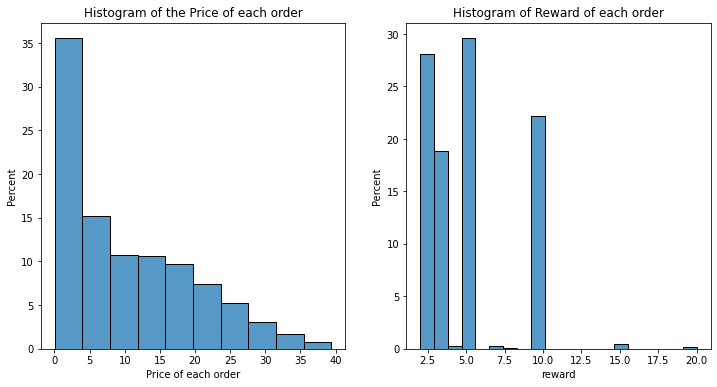

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

sns.histplot(trans_reward, x = 'amount', bins = 10, ax = ax1, stat = 'percent')
ax1.set_title('Histogram of the Price of each order')
ax1.set_xlabel('Price of each order')


sns.histplot(trans_reward, x = 'reward', bins = 20, ax = ax2, stat = 'percent')
ax2.set_title('Histogram of Reward of each order')

plt.show()

Most of the order amounts are below 10 dollars. and most of the reward amounts are below 5 dollars.

We still have to find out whether the use of offer change the amount of order.

In [55]:
# Assess ###
# T test ###
def ttest_user(without_offer, with_offer):
    """
    t-test for the amount of orders for a user, to find out whether offer make a significant difference. 
    """
    if (len(with_offer) > 1) and (len(without_offer) > 1):
        tstat,pvalue = stats.ttest_ind(without_offer, with_offer)
    elif (len(with_offer) == 1) and (len(without_offer) > 1):
        tstat,pvalue = stats.ttest_1samp(a=without_offer, popmean = with_offer, alternative = 'two-sided')
        tstat,pvalue = tstat[0],pvalue[0]
    else:
        tstat,pvalue = np.nan, np.nan


    return tstat,pvalue


def ttest_offer(data=trans_reward):
    """
    t-test for the amount of orders for a dataset.
    """
    pvalue_df = pd.DataFrame(columns = ['person_id', 'pvalue'])
    user_set = data['person_id'].unique()
    for user in user_set:
        user_data = data[data['person_id'] == user ]
        reward_isnan = user_data['reward'].isnull()

        if sum(reward_isnan) > 0:
            # group A: the amouts of orders without offer.
            without_offer = user_data.loc[reward_isnan,'amount'].to_numpy()

        else:
            without_offer = np.array([])
        if sum(~reward_isnan) > 0:
            # group B: The sum of amount and reward, which come from the offer used in each order.
            with_offer = user_data.loc[~reward_isnan,['amount', 'reward']].sum(axis = 1).to_numpy()
            
        else:
            with_offer = np.array([])

        tstat,pvalue = ttest_user(without_offer, with_offer)
        pvalue_df = pvalue_df.append({'person_id': user,'static':tstat,'pvalue':pvalue}, ignore_index = True)

    return pvalue_df

discount_pvalue_df = ttest_offer(trans_reward[~trans_reward['bogo']])
bogo_pvalue_df = ttest_offer(trans_reward[~trans_reward['discount']])
%store discount_pvalue_df
%store bogo_pvalue_df

Stored 'discount_pvalue_df' (DataFrame)
Stored 'bogo_pvalue_df' (DataFrame)


In [56]:
%store -r
discount_user = discount_pvalue_df[discount_pvalue_df['pvalue'] < 0.05]['person_id'].astype(int)
bogo_user = bogo_pvalue_df[bogo_pvalue_df['pvalue'] < 0.05]['person_id'].astype(int)

bogo_user.isin(discount_user).sum()

968

In [57]:
bogo_pvalue_df.describe()

,person_id,pvalue,static
count,16321.000000,6020.000000,6020.000000
mean,8497.031738,0.142237,-inf
std,4910.091145,0.235400,NaN
min,0.000000,0.000000,-inf
25%,4248.000000,0.000178,-8.934461
50%,8488.000000,0.018782,-3.755746
75%,12741.000000,0.173057,-1.617988
max,16999.000000,0.997204,82.200000


We will build a model for the offer sensitive users

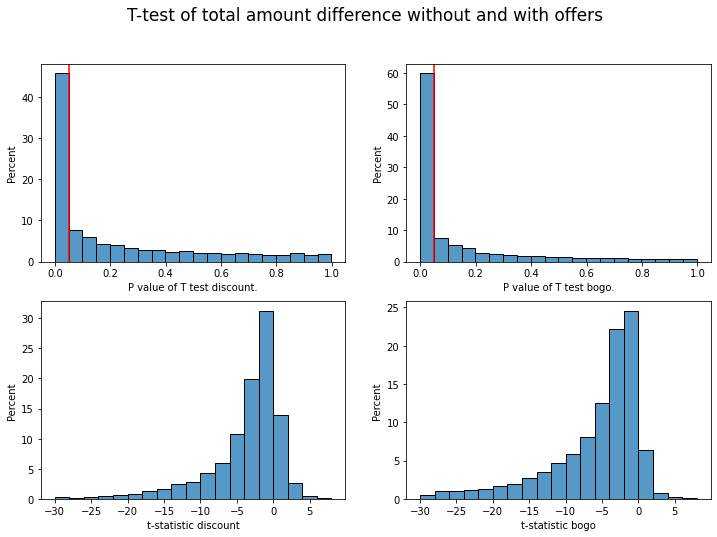

In [108]:
# Visualize 
# For T test result

%store -r discount_pvalue_df
%store -r bogo_pvalue_df
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
fig.suptitle('T-test of total amount difference without and with offers', fontsize=17)
sns.histplot(data = discount_pvalue_df, x = 'pvalue' , stat = 'percent',bins = 20, ax = ax1)
ax1.axvline(x = 0.05, color = 'r')
ax1.set_xlabel('P value of T test discount.')

sns.histplot(data = bogo_pvalue_df, x = 'pvalue', stat = 'percent', bins = 20 ,ax = ax2)
ax2.axvline(x = 0.05, color = 'r')
ax2.set_xlabel('P value of T test bogo.')

sns.histplot(data = discount_pvalue_df, x = 'static', stat = 'percent', bins = range(-30, 10, 2) ,ax = ax3)
ax3.set_xlabel('t-statistic discount')


sns.histplot(data = bogo_pvalue_df, x = 'static', stat = 'percent', bins = range(-30, 10, 2) ,ax = ax4)
ax4.set_xlabel('t-statistic bogo')
plt.show()


Since we want to find out the effect of discount and bogo offers, we will focus on the difference between offer useage.


As we can see that nearly 50% people change their behavior when using offers

In [78]:
def trans_profit(trans_reward = trans_reward, gross_profit_margin=0.3):
    """
    caculate each transaction profit for modeling
    """
    reward_list = trans_reward['reward'].notnull()
    
    # caculate the mean of the transactions without offer
    mean_amount_without_offer = trans_reward[~reward_list].groupby('person_id').mean()['amount'].rename('mean_amount_without_offer')
    n_amount_without_offer = trans_reward[~reward_list].groupby('person_id').count()['amount'].rename('n_amount_without_offer')

    std_amount_without_offer = trans_reward[~reward_list].groupby('person_id').std()['amount'].rename('std_amount_without_offer')
   
    # caculate the mean of the profit without offer
    trans_with_offer = trans_reward[reward_list].copy()
    trans_profit = trans_with_offer.merge(mean_amount_without_offer, on = 'person_id')
    trans_profit = trans_profit.merge(std_amount_without_offer, on = 'person_id', how = 'left')
    trans_profit = trans_profit.merge(n_amount_without_offer, on = 'person_id', how = 'left')

    # t-test for each order to find out does offer affect behavior of order amount.
    trans_profit['p_value'] =pd.DataFrame(stats.ttest_ind_from_stats(trans_profit['amount'] + trans_profit['reward'],
                            0,
                            1,
                            trans_profit['mean_amount_without_offer'],
                            trans_profit['std_amount_without_offer'],
                            trans_profit['n_amount_without_offer'])[1])
    
    trans_profit['profit'] = trans_profit['amount'] * gross_profit_margin - trans_profit['reward'] * (1 - gross_profit_margin)
    trans_profit['profit_margin_with_offer'] = trans_profit['profit'] / trans_profit['amount']
    trans_profit['profit_diff'] = trans_profit['profit'] - trans_profit['mean_amount_without_offer'] * gross_profit_margin
    trans_profit['amount_diff'] = trans_profit['amount'] - trans_profit['mean_amount_without_offer']

    return trans_profit


gross_profit_margin = 0.4
trans_profit = trans_profit(gross_profit_margin=gross_profit_margin)
trans_profit = trans_profit.merge(clean_profile, on = 'person_id', how = 'left')
%store trans_profit

trans_profit.head()

Stored 'trans_profit' (DataFrame)


,person_id,time,amount,reward,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,offer_used,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration,bogo,discount,mean_amount_without_offer,std_amount_without_offer,n_amount_without_offer,p_value,profit,profit_margin_with_offer,profit_diff,amount_diff,gender,age,became_member_on,income
0,3,132,19.89,5.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,5.0,7.0,True,False,23.532000,4.889250,5,0.812341,4.956,0.249170,-4.456800,-3.642000,F,75.0,2017-05-09,100000.0
1,5,522,18.42,7.0,7.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,10.0,10.0,True,True,19.655000,2.510229,2,0.311893,3.168,0.171987,-4.694000,-1.235000,M,68.0,2018-04-26,70000.0
2,12,456,7.14,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,10.0,10.0,False,True,2.826667,2.253139,3,0.136018,1.656,0.231933,0.525333,4.313333,M,58.0,2017-11-11,51000.0
3,13,210,12.33,10.0,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,10.0,5.0,True,False,14.903333,7.298536,3,0.471147,-1.068,-0.086618,-7.029333,-2.573333,F,61.0,2017-09-11,57000.0
4,13,630,12.56,5.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,5.0,True,False,14.903333,7.298536,3,0.782436,2.024,0.161146,-3.937333,-2.343333,F,61.0,2017-09-11,57000.0


In [60]:
print((trans_profit.p_value<0.05).sum())
print((trans_profit.p_value.notnull()).sum())

4999
18583


In [61]:
profit_diff_sum = trans_profit['profit_diff'].sum()
profit_diff_mean = trans_profit['profit_diff'].mean()
profit_diff_positive = (trans_profit['profit_diff'] > 0).mean()
print('With offers, the profit decreased {:.2f} dollars total,\
{:.2f} dollars for each order,if the customers came to starbucks as usual without offers.'\
        .format(abs(profit_diff_sum),abs(profit_diff_mean)))

print('But we get {:.2f}% of the orders with a increase in profit'.format(profit_diff_positive *100))

With offers, the profit decreased 47988.17 dollars total,2.44 dollars for each order,if the customers came to starbucks as usual without offers.
But we get 18.95% of the orders with a increase in profit


Text(0.5, 1.0, 'Difference between amount(with offer) and average amount\n GPM= 0.4')

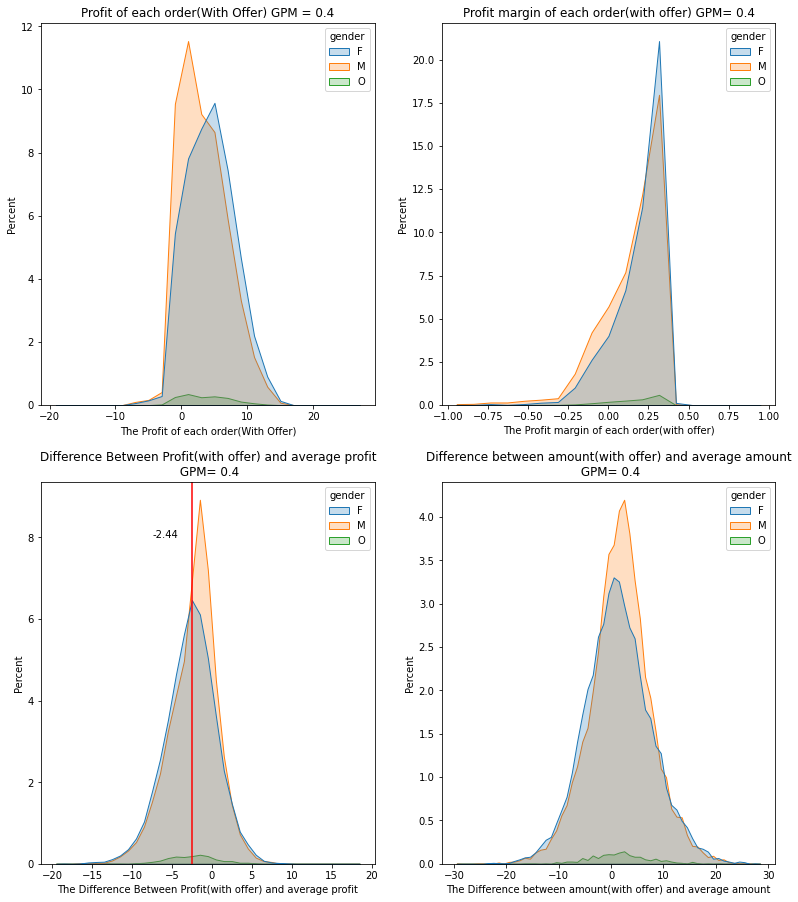

In [62]:
%store -r trans_profit
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2,figsize  = (12,16))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
sns.histplot(data = trans_profit, x = 'profit', bins = range(-20, 30, 2),stat = 'percent', hue = 'gender',element = 'poly', ax = ax0)
ax0.set_xlabel('The Profit of each order(With Offer)')
ax0.set_title('Profit of each order(With Offer) GPM = {}'.format(gross_profit_margin))

sns.histplot(data = trans_profit, x = 'profit_margin_with_offer',bins = np.linspace(-1,1, 20), stat = 'percent',hue = 'gender',element = 'poly', ax = ax1)
ax1.set_xlabel('The Profit margin of each order(with offer)')
ax1.set_title('Profit margin of each order(with offer) GPM= {}'.format(gross_profit_margin))

sns.histplot(data = trans_profit, x = 'profit_diff',bins = range(-20,20 ,1), stat = 'percent',hue = 'gender',element = 'poly', ax = ax2)
ax2.set_xlabel('The Difference Between Profit(with offer) and average profit')
ax2.axvline(x=profit_diff_mean, color='r')
ax2.text(profit_diff_mean - 5, 8,'{:.2f}'.format(profit_diff_mean) )
ax2.set_title('Profit differential (with and without offer GPM= {})'.format(gross_profit_margin))

sns.histplot(data = trans_profit, x = 'amount_diff',bins = range(-30,30 ,1), stat = 'percent',hue = 'gender',element = 'poly', ax = ax3)
ax3.set_xlabel('The Difference between amount(with offer) and average amount')
ax3.set_title('Profit differential (with and without offer GPM= {})'.format(gross_profit_margin))

1. It seems that the orders from female customers have a higher profit.

2. It seems that the orders from male customers have a higher profit difference.


# Section 3: Data Preparation

prepare the data

In [79]:

trans_profit = pd.concat([trans_profit.drop(['gender'], axis=1), pd.get_dummies(trans_profit['gender'], prefix='gender', prefix_sep='_')], axis =1)
%store trans_profit

Stored 'trans_profit' (DataFrame)


In [80]:
trans_profit.columns

Index(['person_id', 'time', 'amount', 'reward', 'offer_reward',
       'BOGO_r10_d10_u5', 'BOGO_r10_d10_u7', 'BOGO_r5_d5_u5', 'BOGO_r5_d5_u7',
       'DIS_r2_d10_u10', 'DIS_r2_d10_u7', 'DIS_r3_d7_u7', 'DIS_r5_d20_u10',
       'offer_used', 'channel_mobile', 'channel_web', 'channel_email',
       'channel_social', 'difficulty', 'duration', 'bogo', 'discount',
       'mean_amount_without_offer', 'std_amount_without_offer',
       'n_amount_without_offer', 'p_value', 'profit',
       'profit_margin_with_offer', 'profit_diff', 'amount_diff', 'age',
       'became_member_on', 'income', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [165]:
df.head()

,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration,mean_amount_without_offer,std_amount_without_offer,n_amount_without_offer,profit_margin_with_offer,profit_diff,amount_diff,age,income,gender_F,gender_M,gender_O
0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,5.0,7.0,23.532000,4.889250,5,0.249170,-4.456800,-3.642000,75.0,100000.0,1,0,0
1,7.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,10.0,10.0,19.655000,2.510229,2,0.171987,-4.694000,-1.235000,68.0,70000.0,0,1,0
2,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,10.0,10.0,2.826667,2.253139,3,0.231933,0.525333,4.313333,58.0,51000.0,0,1,0
3,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,10.0,5.0,14.903333,7.298536,3,-0.086618,-7.029333,-2.573333,61.0,57000.0,1,0,0
4,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,5.0,5.0,14.903333,7.298536,3,0.161146,-3.937333,-2.343333,61.0,57000.0,1,0,0


In [163]:
# remove irrelevant columns
%store -r trans_profit
# drop unnessary columns
df = trans_profit.drop(['amount', 'time', 'reward', 'bogo', 'discount', 'profit', 'offer_used','became_member_on', 'person_id', 'p_value'], axis = 1)
# pair plot for the columns
sns.pairplot(df[['age', 'income', 'mean_amount_without_offer', 'std_amount_without_offer','profit_diff','amount_diff','gender']], hue='gender')
# dorp Nan in profit_diff ,age ,income
df = df.dropna(subset = ['profit_diff','age','income','std_amount_without_offer'], axis = 0)
# add square paramater for better performence on linear model
# df['age2'] = df['age'] ** 2
# df['income2'] = df['income'] ** 2
# df['mean_amount_without_offer2'] = df['mean_amount_without_offer'] ** 2
offer_columns = df.columns.to_series().str.contains('^DIS|BOGO')
# sns.pairplot(df[numeric_features])

df.loc[:, offer_columns] = df.loc[:, offer_columns].fillna(0).astype(int)
f, ax = plt.subplots(figsize = (12,12))
ax = sns.heatmap(df.corr(), annot = True, fmt = ".2f",square = True)

KeyError: "['gender'] not in index"

## 1. Cleaning

### 1. Select x y values

In [122]:
y =  df['profit_diff']
x_drop_list = ['profit_diff',  'amount_diff', 'profit_margin_with_offer' ]
x = df.drop(x_drop_list, axis = 1)
print(x.shape, y.shape)
    

(17780, 23) (17780,)


[156975.22954948377, 57787.79926218406, 31634.726431071136, 19474.78323214746, 13251.013680863116, 9574.047790963115, 7319.026218064522, 5726.364415534725, 4639.896675157299]


<AxesSubplot:>

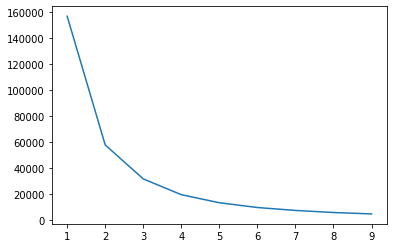

In [83]:
kmeandf  = df.drop(['amount_diff', 'profit_margin_with_offer'], axis = 1)
from sklearn.cluster import KMeans
number_cluster=[]
for ncluster in range(1,10):
    km = KMeans(n_clusters=ncluster, random_state=42)
    km.fit(y.to_numpy().reshape(-1,1))
    number_cluster.append(km.inertia_)
    
print(number_cluster)
sns.lineplot(x=range(1,10), y=number_cluster)

#df.head()

In [84]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(y.to_numpy().reshape(-1,1))
print(km.cluster_centers_)
y_k = km.labels_

kmean_cluster = pd.DataFrame({'label': km.labels_, 'profit_diff':y})
kmean_cluster.groupby('label').agg(['count', 'max', 'min'])


[[-4.24142251]
 [ 1.61541207]
 [-7.71812454]
 [-1.39683439]]


profit_diff                     
            count       max        min
label                                 
0            5149 -2.819200  -5.976500
1            3067  9.061333   0.109333
2            2238 -5.980000 -15.793600
3            7326  0.109000  -2.819000

In [85]:
quan25 = round(y.quantile(0.25),2)
quan50 = round(y.quantile(0.5),2)
quan75 = round(y.quantile(0.75), 2)
print(quan25, quan50, quan75)

y_quan = y.apply(lambda x: 0 if x < quan25 else(1 if x <quan50 else (2 if x <quan75 else 3)))
y_quan.value_counts()


-4.4 -2.19 -0.56


1    4454
2    4448
3    4440
0    4438
Name: profit_diff, dtype: int64

# Secsion 4:Modeling

## 1. Regression

In [86]:
x.head()

,offer_reward,BOGO_r10_d10_u5,BOGO_r10_d10_u7,BOGO_r5_d5_u5,BOGO_r5_d5_u7,DIS_r2_d10_u10,DIS_r2_d10_u7,DIS_r3_d7_u7,DIS_r5_d20_u10,channel_mobile,channel_web,channel_email,channel_social,difficulty,duration,mean_amount_without_offer,std_amount_without_offer,n_amount_without_offer,age,income,gender_F,gender_M,gender_O
0,5.0,0,0,0,1,0,0,0,0,1.0,1.0,1.0,0.0,5.0,7.0,23.532000,4.889250,5,75.0,100000.0,1,0,0
1,7.0,0,0,0,1,1,0,0,0,1.0,1.0,1.0,1.0,10.0,10.0,19.655000,2.510229,2,68.0,70000.0,0,1,0
2,2.0,0,0,0,0,1,0,0,0,1.0,1.0,1.0,1.0,10.0,10.0,2.826667,2.253139,3,58.0,51000.0,0,1,0
3,10.0,1,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,10.0,5.0,14.903333,7.298536,3,61.0,57000.0,1,0,0
4,5.0,0,0,1,0,0,0,0,0,1.0,1.0,1.0,1.0,5.0,5.0,14.903333,7.298536,3,61.0,57000.0,1,0,0


In [115]:
MinMax_features = x.columns[x.columns.str.contains('^DIS|BOGO|channel|difficulty|duration')].tolist()

numeric_features = x.columns.to_list()
numeric_features = [i for i in numeric_features if i not in MinMax_features]

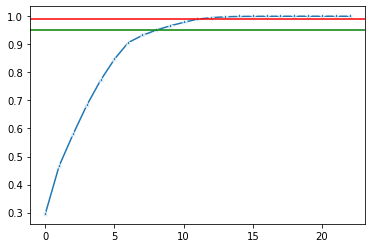

In [88]:
%store -r

pca = PCA()
pca.fit(preprocessor.fit_transform(x))
pca_portion = np.cumsum(pca.explained_variance_ratio_)
n_comp = range(len(pca_portion))
g = sns.lineplot(x = n_comp, y = pca_portion, marker='*')
plt.axhline(0.99, color='r')
plt.axhline(0.95, color='g')

plt.show()

We will use 9 as the number of component.

### 1.1 Linear Regression

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve,RocCurveDisplay, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [123]:
x_train,x_test, y_train, y_test = train_test_split(x, y)

>>> Train set RMSE:
2.1525374226197056
>>> Test set RMSE:
2.174731302243256


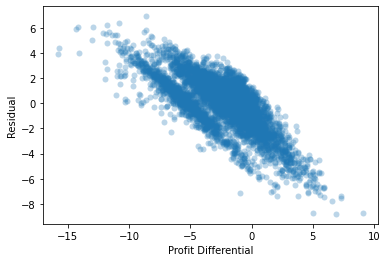

In [157]:
model = LinearRegression()
model.fit(x_train,y_train)

print('>>> Train set RMSE:')
print(mean_squared_error(y_train,model.predict(x_train), squared=False))
print('>>> Test set RMSE:')
print(mean_squared_error(y_test,model.predict(x_test), squared=False))
# print(model.coef_)

residual = model.predict(x_test) - y_test
sns.scatterplot(x=y_test, y=residual, linewidth=0, alpha=0.3)
plt.xlabel('Profit Differential')
plt.ylabel('Residual')
plt.show()


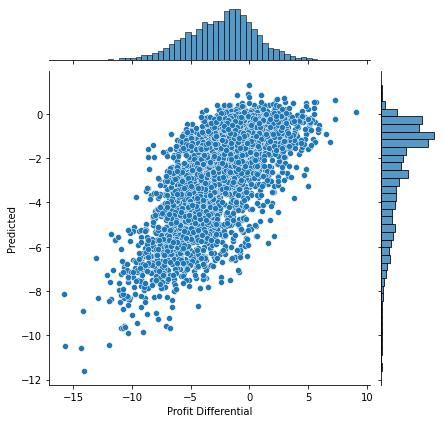

In [175]:
fig = sns.jointplot(x = y_test,y= grid_rfr.predict(x_test))
fig.ax_joint.set_xlabel('Profit Differential')
fig.ax_joint.set_ylabel('Predicted')
plt.show()

### 1.2 Multilayer Perceptron Regression

In [177]:
from xgboost import XGBRegressor

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(),numeric_features),
        ("count", MinMaxScaler(),MinMax_features),

    ]
)

reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', PCA(12)),
    ('xgb', XGBRegressor(random_state=42))
])

grid_params = {
    'xgb__n_estimators': [100,200],
    'xgb__eta': [0.01, 0.1], 
    'xgb__max_depth': [4, 8]

}

grid_xgbr = GridSearchCV(reg, param_grid=grid_params, n_jobs=12, verbose=12, scoring='neg_mean_squared_error')
grid_xgbr.fit(x_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=100......
[CV 3/5; 1/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=100......
[CV 2/5; 1/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=100......
[CV 5/5; 1/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=100......
[CV 5/5; 2/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=200......
[CV 4/5; 1/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=100......
[CV 3/5; 2/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=200......
[CV 2/5; 2/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=200......
[CV 1/5; 2/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=200......
[CV 4/5; 2/8] START xgb__eta=0.01, xgb__max_depth=4, xgb__n_estimators=200......
[CV 2/5; 3/8] START xgb__eta=0.01, xgb__max_depth=8, xgb__n_estimators=100......
[CV 1/5; 3/8] START xgb__eta=0.01, xgb__max_depth

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['offer_reward',
                                                                          'mean_amount_without_offer',
                                                                          'std_amount_without_offer',
                                                                          'n_amount_without_offer',
                                                                          'age',
                                                                          'income',
                                                                          'gender_F',
                                                                          'gender_M',
                                       

In [178]:
grid_xgbr.best_params_

{'xgb__eta': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 100}

>>> Train set RMSE:
1.9430166615417686
>>> Test set RMSE:
2.115584882156958


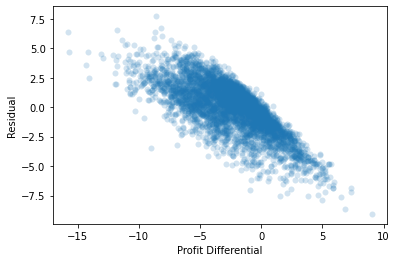

In [179]:
print('>>> Train set RMSE:')
print(mean_squared_error(y_train,grid_xgbr.predict(x_train), squared=False))
print('>>> Test set RMSE:')
print(mean_squared_error(y_test,grid_xgbr.predict(x_test), squared=False))
residual = grid_xgbr.predict(x_test) - y_test 
sns.scatterplot(x = y_test, y = residual, linewidth=0, alpha=0.2)
plt.xlabel('Profit Differential')
plt.ylabel('Residual')
plt.show()

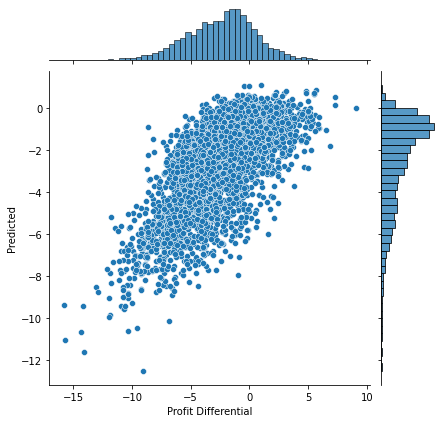

In [174]:
fig = sns.jointplot(x = y_test,y= grid_xgbr.predict(x_test))
fig.ax_joint.set_xlabel('Profit Differential')
fig.ax_joint.set_ylabel('Predicted')
plt.show()

### 1.3 Random Forest Regression

In [154]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Maximum number of levels in tree


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(),numeric_features),
        ("count", MinMaxScaler(),MinMax_features),
    ]
)

rfr_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', PCA(12)),
    ('rfr', RandomForestRegressor(random_state=42))
])

grid_params = {
    'rfr__n_estimators': n_estimators,
    'rfr__max_features': max_features,
    'rfr__max_depth': max_depth,
    'rfr__min_samples_split': min_samples_split,
    'rfr__min_samples_leaf': min_samples_leaf,
    'rfr__bootstrap': bootstrap

}
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid_rfr = RandomizedSearchCV(estimator = rfr_pipe, param_distributions = grid_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_rfr.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rfr__bootstrap=True, rfr__max_depth=34, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__min_samples_split=5, rfr__n_estimators=927; total time=  34.9s
[CV] END rfr__bootstrap=True, rfr__max_depth=34, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__min_samples_split=5, rfr__n_estimators=927; total time=  35.2s
[CV] END rfr__bootstrap=False, rfr__max_depth=38, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__min_samples_split=5, rfr__n_estimators=967; total time= 1.0min
[CV] END rfr__bootstrap=False, rfr__max_depth=38, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__min_samples_split=5, rfr__n_estimators=967; total time= 1.0min
[CV] END rfr__bootstrap=False, rfr__max_depth=38, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__min_samples_split=5, rfr__n_estimators=967; total time= 1.0min
[CV] END rfr__bootstrap=True, rfr__max_depth=34, rfr__max_features=sqrt, rfr__min_samples_leaf=1, rfr__m

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               StandardScaler(),
                                                                               ['offer_reward',
                                                                                'mean_amount_without_offer',
                                                                                'std_amount_without_offer',
                                                                                'n_amount_without_offer',
                                                                                'age',
                                                                                'income',
                                                                                'gender_F',
                                        

>>> Train set RMSE:
1.7546766555846753
>>> Test set RMSE:
2.127606584948147


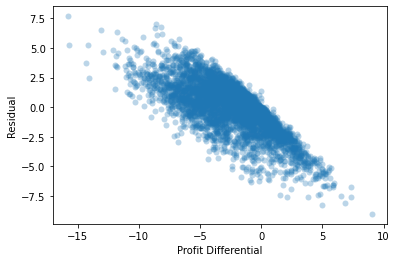

In [160]:

print('>>> Train set RMSE:')
print(mean_squared_error(y_train, grid_rfr.predict(x_train), squared=False))
print('>>> Test set RMSE:')
print(mean_squared_error(y_test, grid_rfr.predict(x_test), squared=False))
residual = grid_rfr.predict(x_test) - y_test 
sns.scatterplot(x = y_test, y = residual, linewidth=0, alpha=0.3)
plt.xlabel('Profit Differential')
plt.ylabel('Residual')
plt.show()

In [148]:
y_test[rf_random.predict(x_test) > 0].mean()
rf_random.best_estimator_.feature_importances_

array([5.92881370e-01, 6.32049131e-04, 5.20705526e-04, 6.72901013e-04,
       1.05123463e-03, 1.21252161e-03, 8.56114739e-04, 2.67401231e-03,
       8.72378022e-04, 3.05764618e-03, 4.94951708e-04, 0.00000000e+00,
       9.30416374e-04, 1.05729363e-02, 3.00953236e-03, 2.00029979e-01,
       4.83212166e-02, 1.76825516e-02, 3.07738640e-02, 7.86864669e-02,
       2.30746517e-03, 2.07072819e-03, 6.88958862e-04])

In [149]:
rf_random.best_params_

array(['offer_reward', 'BOGO_r10_d10_u5', 'BOGO_r10_d10_u7',
       'BOGO_r5_d5_u5', 'BOGO_r5_d5_u7', 'DIS_r2_d10_u10',
       'DIS_r2_d10_u7', 'DIS_r3_d7_u7', 'DIS_r5_d20_u10',
       'channel_mobile', 'channel_web', 'channel_email', 'channel_social',
       'difficulty', 'duration', 'mean_amount_without_offer',
       'std_amount_without_offer', 'n_amount_without_offer', 'age',
       'income', 'gender_F', 'gender_M', 'gender_O'], dtype=object)

R-squared is quite low for an effective model, it may be impossible to predict the exact difference.

## 2. Classifier

In [95]:

x_quan_train, x_quan_test, y_quan_train, y_quan_test = train_test_split(x,y_quan, test_size=0.3, stratify=y_quan, random_state=42)
x_k_train, x_k_test, y_k_train, y_k_test = train_test_split(x,y_k, test_size=0.3, stratify=y_k, random_state=42)

              precision    recall  f1-score   support

           0       0.62      0.74      0.68      1331
           1       0.38      0.38      0.38      1336
           2       0.48      0.36      0.41      1335
           3       0.45      0.48      0.46      1332

    accuracy                           0.49      5334
   macro avg       0.48      0.49      0.48      5334
weighted avg       0.48      0.49      0.48      5334

              precision    recall  f1-score   support

           0       0.48      0.49      0.49      1545
           1       0.07      0.09      0.08       920
           2       0.00      0.00      0.00       671
           3       0.41      0.27      0.33      2198

    accuracy                           0.27      5334
   macro avg       0.24      0.21      0.22      5334
weighted avg       0.32      0.27      0.29      5334



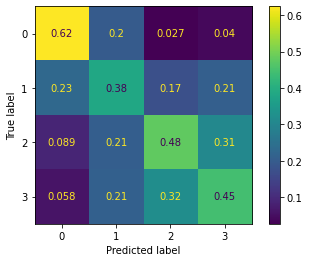

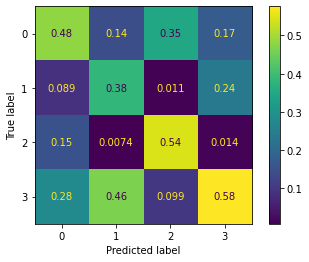

In [107]:
from xgboost import XGBClassifier
# numeric_features = ['age','income','mean_amount_without_offer','age2','income2','mean_amount_without_offer2']

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(),numeric_features),
        ("count", MinMaxScaler(),MinMax_features),

    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', PCA(12)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='aucpr',nthread=1, n_jobs=4, use_label_encoder=False))
])

grid_params = {
    'xgb__eta':[0.05, 0.1,],
    'xgb__gamma':[0, 0.1 ,0.01],
    'xgb__lambda':[1],
    'xgb__max_depth':[10, 15,20]
}

grid_quan = GridSearchCV(clf, param_grid=grid_params, n_jobs=12)
grid_quan.fit(x_quan_train, y_quan_train)
y_quan_pred = grid_quan.predict(x_quan_test)
print(classification_report(y_quan_test,y_quan_pred))
ConfusionMatrixDisplay.from_estimator( grid_quan,x_quan_test, y_quan_test, normalize = 'pred')



grid_k = GridSearchCV(clf, param_grid=grid_params, n_jobs=12)
grid_k.fit(x_k_train, y_k_train)
y_k_pred = grid_quan.predict(x_k_test)
print(classification_report(y_k_test,y_k_pred))
ConfusionMatrixDisplay.from_estimator( grid_k,x_k_test, y_k_test, normalize = 'pred')



In [106]:
grid_k.best_params_

{'xgb__eta': 0.1, 'xgb__gamma': 0.01, 'xgb__lambda': 1}

#### 4. Random Forest Classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier
RFC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=12)),
    ('rfc', RandomForestClassifier(class_weight='balanced',random_state=42))
])
param_grid = {
    'rfc__n_estimators':[200, 400, 600]
}
grid_rfc = GridSearchCV(RFC, param_grid=param_grid,n_jobs=4, scoring='roc_auc_ovr')
grid_rfc.fit(x_quan_train, y_quan_train)
%store grid_rfc

Stored 'grid_rfc' (GridSearchCV)


              precision    recall  f1-score   support

           0       0.48      0.45      0.46      1545
           1       0.04      0.06      0.05       920
           2       0.00      0.01      0.01       671
           3       0.39      0.24      0.29      2198

    accuracy                           0.24      5334
   macro avg       0.23      0.19      0.20      5334
weighted avg       0.31      0.24      0.26      5334



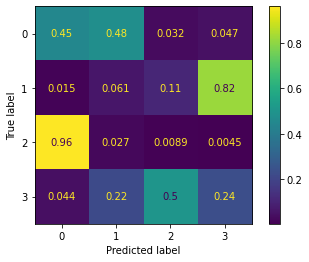

In [101]:
y_k_pred = grid_rfc.predict(x_k_test)
print(classification_report(y_k_test,y_k_pred))
ConfusionMatrixDisplay.from_estimator( grid_rfc,x_k_test, y_k_test, normalize = 'true')

#### 5. MLP

# section 5: Next Step

1. From the evaluation, we can see that , it is possible to make more profit by offers.
2. We can use MLP model to predict the effect of offers on profit and control the total cost of offers. We may deloy the modle for further test.
3. Offer is also a kind of gift for loyal customers, we should not exclude them only for better profit.
4. As the offer deloyed for longer period, we can dig more on the long term effects. 

Assumptions:

1. The model use a consist gross profit margin, which is not very accurate for the profit prediction of each order.
2. We assume customers' order follow normal distribution and have consistant pattern, in actual they may come alone or with different numbers of friends, which should make a lot of different.